# 1. Load packages

The link to get [ImageAnalysis3](https://github.com/zhengpuas47/ImageAnalysis3) 

or the Zhuang lab archived [source_tools](https://github.com/ZhuangLab/Chromatin_Analysis_2020_cell/tree/master/sequential_tracing/source)

In [1]:
%run "C:\Users\shiwei\Documents\ImageAnalysis3\required_files\Startup_py3.py"
sys.path.append(r"C:\Users\shiwei\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

import pandas as pd

2308


See **functions** in the repository for [AnalysisTool_Chromatin](../../README.md)

In [2]:
# Chromatin_analysis_tools (ATC)
# Get path for the py containing functions
import os
import sys
import importlib
module_path =r'C:\Users\shiwei\Documents\AnalysisTool_Chromatin'
if module_path not in sys.path:
    sys.path.append(module_path)
    
# import relevant modules
import gene_selection 
importlib.reload(gene_selection)
import gene_to_loci
importlib.reload(gene_to_loci)
import gene_activity
importlib.reload(gene_activity)
import loci_1d_features
importlib.reload(loci_1d_features)  

import atac_to_loci
importlib.reload(atac_to_loci)

<module 'atac_to_loci' from 'C:\\Users\\shiwei\\Documents\\AnalysisTool_Chromatin\\atac_to_loci.py'>

In [3]:
import seaborn as sns
import scanpy as sc
import numpy as np

## 1.1 Define output folder

In [4]:
output_main_folder = r'L:\Shiwei\Figures\MOp_draft_2023_v1\Nuclear_organization'
output_analysis_folder = os.path.join(output_main_folder, 'analysis')
output_figure_folder = os.path.join(output_main_folder, 'figures')

make_output_folder = True

if make_output_folder and not os.path.exists(output_analysis_folder):
    os.makedirs(output_analysis_folder)
    print(f'Generating analysis folder: {output_analysis_folder}.')
elif os.path.exists(output_analysis_folder):
    print(f'Use existing analysis folder: {output_analysis_folder}.')
    
if make_output_folder and not os.path.exists(output_figure_folder):
    os.makedirs(output_figure_folder)
    print(f'Generating figure folder: {output_figure_folder}.')
elif os.path.exists(output_figure_folder):
    print(f'Use existing figure folder: {output_figure_folder}.')

Use existing analysis folder: L:\Shiwei\Figures\MOp_draft_2023_v1\Nuclear_organization\analysis.
Use existing figure folder: L:\Shiwei\Figures\MOp_draft_2023_v1\Nuclear_organization\figures.


## 1.2 setting up plotting parameters

In [5]:
sc.settings.n_jobs = 24
sc.settings.set_figure_params(dpi=150, dpi_save=300, frameon=False, 
                              figsize=(4, 4), fontsize=8, facecolor='white', transparent=True)
sc.settings.figdir = output_figure_folder

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

In [6]:
selected_cell_labels = ['L2/3 IT','L4/5 IT','L5 IT','L6 IT','L5 ET','L5/6 NP','L6 CT','L6b',
                           'Sst','Pvalb','Lamp5','Sncg','Vip',
                           'Astro','Oligo','OPC','Micro','Endo','VLMC','SMC','Peri', 
                           #'other',
                          ]

celltype_palette = {'Astro':'lightcoral', 
                    'Endo':'skyblue', 
                    'L2/3 IT':'gold', 
                    'L4/5 IT':'darkorange', 
                    'L5 ET':'mediumseagreen', 
                    'L5 IT':'aqua',
                    'L5/6 NP':'darkgreen',
                    'L6 CT':'brown',
                    'L6 IT':'magenta',
                    'L6b':'blue', 
                    'Lamp5':'orange', 
                    'Micro':'peachpuff',
                    'OPC':'thistle', 
                    'Oligo':'darkviolet',
                    'Peri':'sandybrown',
                    'Pvalb':'springgreen',
                    'SMC':'rosybrown',
                    'Sncg':'darkkhaki',
                    'Sst':'steelblue', 
                    'VLMC':'saddlebrown', 
                    'Vip':'red',
                    'other':'slategray'}



# 2. Load codebook and chr2Zxys

## Codebook

**Codebook** example from [codebook_link](../resources/MERFISH_loci_adjacent_peaks_center.csv)

In [7]:
# load codebook
# L drive is Crick Pu_SSD_0
codebook_save_folder=r'\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\MouseBrain_PostAnalysis_20230201\postanalysis_vCW2_sorted'

# Load sorted codebook (allows direct matrix slicing) with cell type info
# Load codebook (then sort to allow direct matrix slicing) with cell type info

codebook_fname = os.path.join(codebook_save_folder,'MERFISH_loci_adjacent_genes_tss_more_res.csv')
codebook_df = pd.read_csv (codebook_fname, index_col=0)

# sort df temporailiy so matrix can be sliced by df order directly
codebook_df = loci_1d_features.sort_loci_df_by_chr_order (codebook_df)

codebook_df.head()

,name,id,chr,chr_order,library,dtype,adjacent_genes_0kb_tss,adjacent_genes_10kb_tss,adjacent_genes_50kb_tss,adjacent_genes_100kb_tss,adjacent_genes_200kb_tss,adjacent_genes_500kb_tss,adjacent_genes_1000kb_tss,adjacent_genes_1500kb_tss,adjacent_genes_2000kb_tss
loci_name,,,,,,,,,,,,,,,
chr1_3742742_3759944,1:3742742-3759944,1,1,0,CTP11,combo,intergenic,intergenic,intergenic,Xkr4,Xkr4,Gm18956; Gm7341; Xkr4,Gm18956; Gm2053; Gm6085; Gm6101; Gm6119; Gm734...,Atp6v1h; Gm16041; Gm17101; Gm18956; Gm2053; Gm...,Atp6v1h; Gm16041; Gm17101; Gm18956; Gm2053; Gm...
chr1_6245958_6258969,1:6245958-6258969,2,1,1,CTP11,combo,intergenic,intergenic,4732440D04Rik; Rb1cc1,4732440D04Rik; Rb1cc1,4732440D04Rik; Gm19026; Gm2147; Rb1cc1,4732440D04Rik; Gm19026; Gm2147; Npbwr1; Rb1cc1...,4732440D04Rik; Gm19026; Gm2147; Gm5694; Gm7182...,4732440D04Rik; Atp6v1h; Gm16041; Gm17101; Gm19...,4732440D04Rik; Atp6v1h; Gm16041; Gm17101; Gm19...
chr1_8740008_8759916,1:8740008-8759916,3,1,2,CTP11,combo,intergenic,intergenic,Gm15452,Gm15452,Gm15452,Gm15452,1700034P13Rik; 2610203C22Rik; Adhfe1; Gm15452;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...
chr1_9627926_9637875,1:9627926-9637875,1,1,3,CTP13,combo,2610203C22Rik,2610203C22Rik,2610203C22Rik,2610203C22Rik; Adhfe1; Gm6161; Mybl1; Rrs1,1700034P13Rik; 2610203C22Rik; Adhfe1; Gm18300;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Cops5; C...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; A830018L16Rik; A...
chr1_9799472_9811359,1:9799472-9811359,2,1,4,CTP13,combo,Gm6195,Gm6195; Sgk3,Gm6195; Sgk3,1700034P13Rik; Gm6195; Mcmdc2; Mybl1; Sgk3; Vc...,1700034P13Rik; 2610203C22Rik; Gm6195; Mcmdc2; ...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; A830018L16Rik; A...


## load gene info df

Example of data [annotation](../../../external/resources/MOp_10x_snRNA_chr_info_NEW_from_transcriptome_FORMAT.csv) in the repository

Data can be generated using the notebook with snRNA data

[external/scripts/genome_annotation/1_genomic_info_for_mop_genes_using_ensembl_transcriptome](../../../external/scripts/genome_annotation/1_genomic_info_for_mop_genes_using_ensembl_transcriptome.ipynb)

In [8]:
# load gene annotation (covering all genes from the SMART-seq) for chr locus
# this should be enough since we can only analyze the genes with info from SMARTseq
# also we used Ensembl for both gene2loci and loci2gene to be consistent 
gene_folder = r'\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\MouseBrain_PostAnalysis_20230201\postanalysis_vCW2_sorted'
gene_annotation_df = pd.read_csv(os.path.join(gene_folder, "MOp_10x_snRNA_chr_info_NEW_from_transcriptome_FORMAT.csv"),index_col=0)
print(len(gene_annotation_df))
gene_annotation_df.head()

24659


,chr,start,end,gene_biotype,coding_strand,length,genomic_position
gene,,,,,,,
Xkr4,1,3205901,3671498,protein_coding,-1,465597,chr1_3205901_3671498
Gm1992,1,3466587,3513553,antisense,1,46966,chr1_3466587_3513553
Gm37381,1,3905739,3986215,lincRNA,-1,80476,chr1_3905739_3986215
Rp1,1,3999557,4409241,protein_coding,-1,409684,chr1_3999557_4409241
Sox17,1,4490931,4497354,protein_coding,-1,6423,chr1_4490931_4497354


In [9]:
np.unique(gene_annotation_df['gene_biotype'])

array(['3prime_overlapping_ncRNA', 'IG_C_gene', 'IG_V_gene',
       'IG_V_pseudogene', 'TR_C_gene', 'TR_V_gene', 'TR_V_pseudogene',
       'antisense', 'antisense;lincRNA', 'antisense;lncRNA',
       'antisense;misc_RNA', 'antisense;processed_transcript',
       'bidirectional_promoter_lncRNA', 'lincRNA', 'lincRNA;lncRNA',
       'lincRNA;processed_pseudogene', 'lincRNA;processed_transcript',
       'lincRNA;protein_coding', 'lincRNA;snoRNA', 'macro_lncRNA',
       'polymorphic_pseudogene', 'processed_pseudogene',
       'processed_transcript', 'protein_coding',
       'protein_coding;transcribed_unprocessed_pseudogene',
       'transcribed_processed_pseudogene',
       'transcribed_unitary_pseudogene',
       'transcribed_unprocessed_pseudogene',
       'translated_unprocessed_pseudogene', 'unitary_pseudogene',
       'unprocessed_pseudogene'], dtype=object)

# 3. Add gene length abd long gene information

## subset codebook columns

In [10]:
codebook_df.head()

,name,id,chr,chr_order,library,dtype,adjacent_genes_0kb_tss,adjacent_genes_10kb_tss,adjacent_genes_50kb_tss,adjacent_genes_100kb_tss,adjacent_genes_200kb_tss,adjacent_genes_500kb_tss,adjacent_genes_1000kb_tss,adjacent_genes_1500kb_tss,adjacent_genes_2000kb_tss
loci_name,,,,,,,,,,,,,,,
chr1_3742742_3759944,1:3742742-3759944,1,1,0,CTP11,combo,intergenic,intergenic,intergenic,Xkr4,Xkr4,Gm18956; Gm7341; Xkr4,Gm18956; Gm2053; Gm6085; Gm6101; Gm6119; Gm734...,Atp6v1h; Gm16041; Gm17101; Gm18956; Gm2053; Gm...,Atp6v1h; Gm16041; Gm17101; Gm18956; Gm2053; Gm...
chr1_6245958_6258969,1:6245958-6258969,2,1,1,CTP11,combo,intergenic,intergenic,4732440D04Rik; Rb1cc1,4732440D04Rik; Rb1cc1,4732440D04Rik; Gm19026; Gm2147; Rb1cc1,4732440D04Rik; Gm19026; Gm2147; Npbwr1; Rb1cc1...,4732440D04Rik; Gm19026; Gm2147; Gm5694; Gm7182...,4732440D04Rik; Atp6v1h; Gm16041; Gm17101; Gm19...,4732440D04Rik; Atp6v1h; Gm16041; Gm17101; Gm19...
chr1_8740008_8759916,1:8740008-8759916,3,1,2,CTP11,combo,intergenic,intergenic,Gm15452,Gm15452,Gm15452,Gm15452,1700034P13Rik; 2610203C22Rik; Adhfe1; Gm15452;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...
chr1_9627926_9637875,1:9627926-9637875,1,1,3,CTP13,combo,2610203C22Rik,2610203C22Rik,2610203C22Rik,2610203C22Rik; Adhfe1; Gm6161; Mybl1; Rrs1,1700034P13Rik; 2610203C22Rik; Adhfe1; Gm18300;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Cops5; C...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; A830018L16Rik; A...
chr1_9799472_9811359,1:9799472-9811359,2,1,4,CTP13,combo,Gm6195,Gm6195; Sgk3,Gm6195; Sgk3,1700034P13Rik; Gm6195; Mcmdc2; Mybl1; Sgk3; Vc...,1700034P13Rik; 2610203C22Rik; Gm6195; Mcmdc2; ...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; A830018L16Rik; A...


In [11]:
gene_col = 'adjacent_genes_2000kb_tss'
gene_codebook_df = codebook_df.copy(deep=True)
sel_cols = ['name','id','chr','chr_order','library',gene_col]
gene_codebook_df = gene_codebook_df[sel_cols]

gene_codebook_df.head()

,name,id,chr,chr_order,library,adjacent_genes_2000kb_tss
loci_name,,,,,,
chr1_3742742_3759944,1:3742742-3759944,1,1,0,CTP11,Atp6v1h; Gm16041; Gm17101; Gm18956; Gm2053; Gm...
chr1_6245958_6258969,1:6245958-6258969,2,1,1,CTP11,4732440D04Rik; Atp6v1h; Gm16041; Gm17101; Gm19...
chr1_8740008_8759916,1:8740008-8759916,3,1,2,CTP11,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...
chr1_9627926_9637875,1:9627926-9637875,1,1,3,CTP13,1700034P13Rik; 2610203C22Rik; A830018L16Rik; A...
chr1_9799472_9811359,1:9799472-9811359,2,1,4,CTP13,1700034P13Rik; 2610203C22Rik; A830018L16Rik; A...


## add gene length for protein coding gene information

In [12]:
'protein_coding' in 'lincRNA;protein_coding'

True

In [13]:
gene_lens_list = []
longgene_num_list1 = []
longgene_num_list2 = []
longgene_name_list1 = []
longgene_name_list2 = []

longgene_len1 = 100
longgene_len2 = 300

total_gen_len_list = [] 
ave_gen_len_list = [] 

sel_genes_list = gene_codebook_df[gene_col].tolist()
for sel_genes in sel_genes_list:
    sel_genes = sel_genes.split('; ')
    gene_lens = []
    for _g in sel_genes:
        if _g in gene_annotation_df.index:
            if 'protein_coding' in gene_annotation_df.loc[_g]['gene_biotype']:
                gene_len = gene_annotation_df.loc[_g]['length']/1000
                gene_lens.append(gene_len)
            else:
                gene_lens.append(np.nan)
        else:
            gene_lens.append(np.nan)
    gene_lens_list.append(gene_lens)
    longgene_num_list1.append(np.sum(np.array(gene_lens)>longgene_len1))
    longgene_num_list2.append(np.sum(np.array(gene_lens)>longgene_len2))
    
    longgene_name_1 = np.array(sel_genes)[np.where(np.array(gene_lens)>longgene_len1)[0]]
    longgene_name_list1.append('; '.join(longgene_name_1))
    longgene_name_2 = np.array(sel_genes)[np.where(np.array(gene_lens)>longgene_len2)[0]]
    longgene_name_list2.append('; '.join(longgene_name_2))

    total_gen_len_list.append(np.nansum(gene_lens))
    ave_gen_len_list.append(np.nanmean(gene_lens))

gene_codebook_df['gene_len']=gene_lens_list
gene_codebook_df['num_100k_gene']=longgene_num_list1
gene_codebook_df['num_300k_gene']=longgene_num_list2
gene_codebook_df['100k_gene']=longgene_name_list1
gene_codebook_df['300k_gene']=longgene_name_list2

gene_codebook_df['total_gen_len']=total_gen_len_list
gene_codebook_df['mean_gen_len']=ave_gen_len_list

C:\Users\shiwei\AppData\Local\Temp\2\ipykernel_2308\2465717559.py:36: RuntimeWarning: Mean of empty slice
  ave_gen_len_list.append(np.nanmean(gene_lens))


# 4. Add RNA expression status

In [14]:
gene_codebook_df[:1]

,name,id,chr,chr_order,library,adjacent_genes_2000kb_tss,gene_len,num_100k_gene,num_300k_gene,100k_gene,300k_gene,total_gen_len,mean_gen_len
loci_name,,,,,,,,,,,,,
chr1_3742742_3759944,1:3742742-3759944,1,1,0,CTP11,Atp6v1h; Gm16041; Gm17101; Gm18956; Gm2053; Gm...,"[92.511, nan, nan, nan, nan, nan, nan, nan, na...",3,2,Rgs20; Rp1; Xkr4,Rp1; Xkr4,1245.839,138.426556


## load RNA normalized data

Data can be generated by notebook

[external/scripts/sn_rna/2_prepare_and_rename_sn_rna_mop](../../../external/scripts/sn_rna/2_prepare_and_rename_sn_rna_mop.ipynb)

In [15]:
target_adata_folder = r'L:\Shiwei\DNA_MERFISH_analysis\10x_nuclei_v3_MOp_AIBS\Analysis_10X_nuclei_v3_AIBS\processed'
# load the processed adata that has UMAP and label information
adata = sc.read(os.path.join(target_adata_folder,'MOp_10x_sn_labeled.h5ad'))
#adata = sc.read(os.path.join(target_adata_folder,'MOp_10x_sn_filtered_unnorm_w_label.h5ad'))
adata_ori = adata.raw.to_adata()

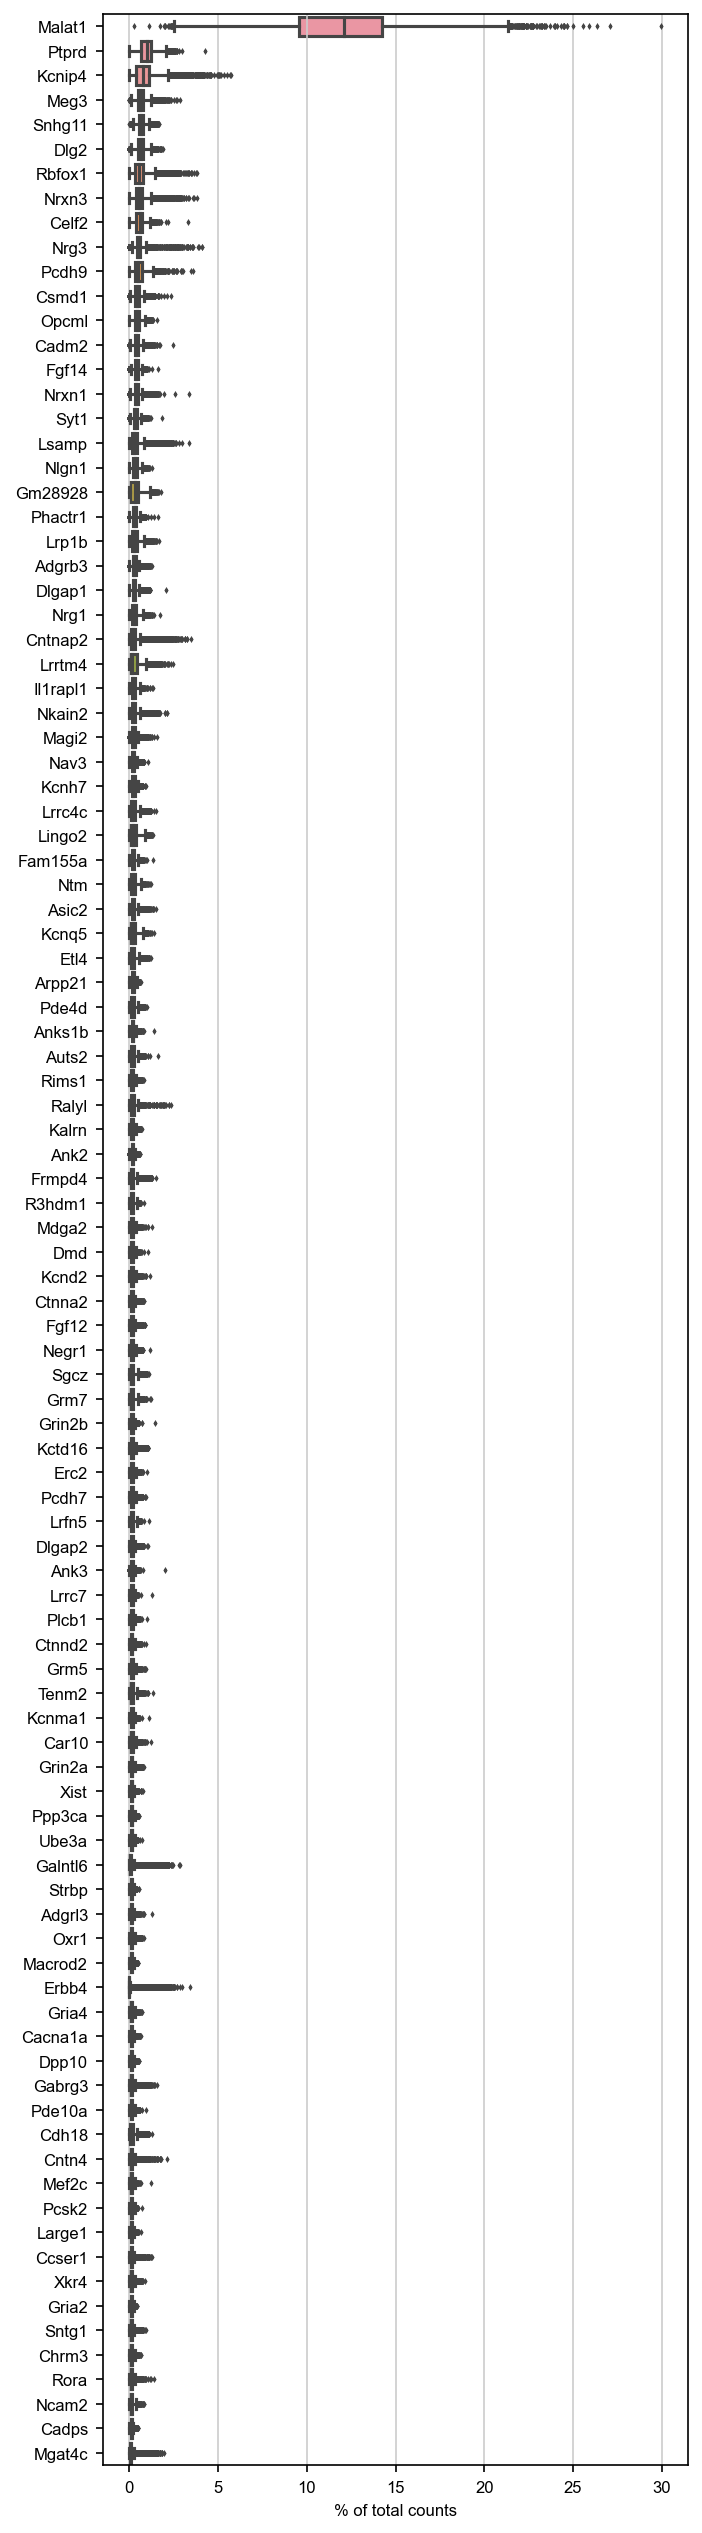

In [18]:
%matplotlib inline
sc.pl.highest_expr_genes(adata_ori, n_top=100, )

In [17]:
gene_sort_bymean = adata_ori.var.sort_values(by='mean_counts')['mean_counts'][::-1][:1000]
gene_sort_bymean

Malat1    2061.521484
Ptprd      161.445450
Kcnip4     137.245682
Dlg2       113.455383
Meg3       112.848030
             ...     
Gm3764       2.575835
Lnpk         2.572001
Dpysl2       2.568167
Gmcl1        2.566126
Abhd18       2.564507
Name: mean_counts, Length: 1000, dtype: float32

In [19]:
p_th = 90

gene_means = np.mean(adata_ori.X.toarray(), axis=0)
malat1_index = np.where(adata_ori.var_names=='Malat1')[0]
gene_means[malat1_index] = np.median(gene_means)
expression_th = np.percentile(gene_means,p_th)
expression_th

In [20]:
expression_th

1.0829506039619472

## relative active genes

In [22]:
active_genes_byGroup = {}

for _group in np.unique(adata_ori.obs['subclass_label_new'])[:]:
    sel_adata = adata_ori[adata_ori.obs['subclass_label_new']==_group]
    # gene expression mean for all genes for the celltype ~ non-neuron expression are thus relative and 'overestimated'
    gene_means = np.mean(sel_adata.X.toarray(), axis=0)
    malat1_index = np.where(adata_ori.var_names=='Malat1')[0]
    gene_means[malat1_index] = np.median(gene_means)
    #gene_means = np.log10(gene_means+1)
    expression_th = np.percentile(gene_means,p_th) # 75 for active, similar to the loci wise percentile
    # relative active genes 
    active_genes = sel_adata.var_names[gene_means>expression_th]
    active_genes_byGroup[_group] = active_genes


In [23]:
import tqdm
active_genes_list_byGroup = {}
sel_genes_list = gene_codebook_df[gene_col].tolist()

for _group, _active_genes in tqdm.tqdm(active_genes_byGroup.items()):
    active_genes_list_byGroup[_group]=[]
    for sel_genes in sel_genes_list:
        sel_genes = sel_genes.split('; ')
        active_genes_loci = np.intersect1d(sel_genes, _active_genes)
        active_genes_loci = '; '.join(active_genes_loci)
        active_genes_list_byGroup[_group].append(active_genes_loci)


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [01:56<00:00,  6.46s/it]


In [24]:
active_genes_list_byGroup[_group][:3]

['Atp6v1h; Xkr4', 'Atp6v1h; Pcmtd1; Rb1cc1', 'Arfgef1; Cspp1; Pcmtd1; Sntg1']

In [25]:
active_genes_list_byGroup['Astro'][:3]

['Atp6v1h; Rgs20',
 'Atp6v1h; Pcmtd1; Rb1cc1; Rgs20',
 'Adhfe1; Arfgef1; Cspp1; Pcmtd1; Sntg1']

In [26]:
for _group, _active_genes_list in tqdm.tqdm(active_genes_list_byGroup.items()):
    gene_codebook_df[f'rel_active_{gene_col}_{_group}'] = _active_genes_list

100%|████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 1636.66it/s]


## absoulte active genes

In [27]:
active_genes_byGroup = {}

gene_means = np.mean(adata_ori.X.toarray(), axis=0)
malat1_index = np.where(adata_ori.var_names=='Malat1')[0]
gene_means[malat1_index] = np.median(gene_means)
expression_th = np.percentile(gene_means,p_th)

for _group in np.unique(adata_ori.obs['subclass_label_new'])[:]:
    sel_adata = adata_ori[adata_ori.obs['subclass_label_new']==_group]
    # absolute active genes 
    sel_gene_means = np.mean(sel_adata.X.toarray(), axis=0)
    sel_gene_means[malat1_index] = np.median(sel_gene_means)
    #sel_gene_means = np.log10(sel_gene_means+1)
    active_genes = sel_adata.var_names[sel_gene_means>expression_th]
    active_genes_byGroup[_group] = active_genes

In [28]:
for _group in active_genes_byGroup.keys():
    active_genes = active_genes_byGroup[_group]
    print(_group,len(active_genes))

Astro 779
Endo 1243
L2/3 IT 2777
L4/5 IT 2234
L5 ET 3946
L5 IT 3019
L5/6 NP 1754
L6 CT 2243
L6 IT 2597
L6b 2754
Lamp5 1769
Micro 340
OPC 631
Oligo 538
Pvalb 2419
Sncg 2165
Sst 2094
Vip 1288


In [29]:
import tqdm
abs_active_genes_list_byGroup = {}
sel_genes_list = gene_codebook_df[gene_col].tolist()

for _group, _active_genes in tqdm.tqdm(active_genes_byGroup.items()):
    abs_active_genes_list_byGroup[_group]=[]
    for sel_genes in sel_genes_list:
        sel_genes = sel_genes.split('; ')
        active_genes_loci = np.intersect1d(sel_genes, _active_genes)
        active_genes_loci = '; '.join(active_genes_loci)
        abs_active_genes_list_byGroup[_group].append(active_genes_loci)


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [01:28<00:00,  4.90s/it]


In [30]:
active_genes_list_byGroup[_group][:3]

['Atp6v1h; Xkr4', 'Atp6v1h; Pcmtd1; Rb1cc1', 'Arfgef1; Cspp1; Pcmtd1; Sntg1']

In [31]:
active_genes_list_byGroup['Astro'][:3]

['Atp6v1h; Rgs20',
 'Atp6v1h; Pcmtd1; Rb1cc1; Rgs20',
 'Adhfe1; Arfgef1; Cspp1; Pcmtd1; Sntg1']

In [32]:
for _group, _active_genes_list in tqdm.tqdm(abs_active_genes_list_byGroup.items()):
    gene_codebook_df[f'abs_active_{gene_col}_{_group}'] = _active_genes_list

100%|████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 2248.82it/s]


# 5. Save as h5 to keep the length list 

In [33]:
gene_codebook_df[:1]

,name,id,chr,chr_order,library,adjacent_genes_2000kb_tss,gene_len,num_100k_gene,num_300k_gene,100k_gene,...,abs_active_adjacent_genes_2000kb_tss_L6 IT,abs_active_adjacent_genes_2000kb_tss_L6b,abs_active_adjacent_genes_2000kb_tss_Lamp5,abs_active_adjacent_genes_2000kb_tss_Micro,abs_active_adjacent_genes_2000kb_tss_OPC,abs_active_adjacent_genes_2000kb_tss_Oligo,abs_active_adjacent_genes_2000kb_tss_Pvalb,abs_active_adjacent_genes_2000kb_tss_Sncg,abs_active_adjacent_genes_2000kb_tss_Sst,abs_active_adjacent_genes_2000kb_tss_Vip
loci_name,,,,,,,,,,,,,,,,,,,,,
chr1_3742742_3759944,1:3742742-3759944,1,1,0,CTP11,Atp6v1h; Gm16041; Gm17101; Gm18956; Gm2053; Gm...,"[92.511, nan, nan, nan, nan, nan, nan, nan, na...",3,2,Rgs20; Rp1; Xkr4,...,Atp6v1h; Rgs20; Xkr4,Atp6v1h; Rgs20; Xkr4,Atp6v1h; Xkr4,,Xkr4,Xkr4,Atp6v1h; Xkr4,Atp6v1h; Xkr4,Atp6v1h; Xkr4,Xkr4


In [34]:
output_fname = os.path.join(output_analysis_folder, f'MERFISH_loci_gene_info_and_activity_2Mb_bysubclass.h5')
gene_codebook_df.to_hdf(output_fname, key='df', mode='w')

C:\Users\shiwei\AppData\Local\Temp\2\ipykernel_2308\481992779.py:2: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->Index(['name', 'id', 'chr', 'library', 'adjacent_genes_2000kb_tss', 'gene_len',
       '100k_gene', '300k_gene', 'rel_active_adjacent_genes_2000kb_tss_Astro',
       'rel_active_adjacent_genes_2000kb_tss_Endo',
       'rel_active_adjacent_genes_2000kb_tss_L2/3 IT',
       'rel_active_adjacent_genes_2000kb_tss_L4/5 IT',
       'rel_active_adjacent_genes_2000kb_tss_L5 ET',
       'rel_active_adjacent_genes_2000kb_tss_L5 IT',
       'rel_active_adjacent_genes_2000kb_tss_L5/6 NP',
       'rel_active_adjacent_genes_2000kb_tss_L6 CT',
       'rel_active_adjacent_genes_2000kb_tss_L6 IT',
       'rel_active_adjacent_genes_2000kb_tss_L6b',
       'rel_active_adjacent_genes_2000kb_tss_Lamp5',
       'rel_active_adjacent_genes_2000kb_tss_Micro',
       'rel_